In [1]:
!pip install -q "transformers[torch]>=4.38" "datasets>=2.18" "evaluate>=0.4" "accelerate>=0.28"
!pip install -q scikit-learn pyarrow

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

2025-10-24 13:54:11.612787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761314051.636313     235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761314051.643536     235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imports successful!
PyTorch version: 2.6.0+cu124
CUDA is available: True
Number of GPUs: 2


In [3]:
class Config:
    # Model identifier from Hugging Face Hub
    MODEL_NAME = "microsoft/deberta-v3-base"

    # Dataset identifier for the BeaverTails benchmark
    DATASET_NAME = "PKU-Alignment/BeaverTails"

    # Directory where the final fine-tuned model will be saved
    OUTPUT_DIR = "deberta-compliance-classifier"

    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 1 
    BATCH_SIZE_PER_DEVICE = 16 # Batch size for each of the 2 GPUs
    GRADIENT_ACCUMULATION_STEPS = 2 # Effectively simulates a larger batch size (16*2*2=64)

    NUM_SAMPLES_TRAIN = 40000
    NUM_SAMPLES_TEST = 5000
    SEED = 42

config = Config()

In [4]:
print(f"Loading dataset stream: {config.DATASET_NAME}")
full_dataset_stream = load_dataset(config.DATASET_NAME, split="330k_train", streaming=True)

print("Creating a balanced subset for training and testing...")
safe_samples = list(
    full_dataset_stream.filter(lambda x: x['is_safe'] and x['prompt'] and x['response']).take(
        config.NUM_SAMPLES_TRAIN // 2 + config.NUM_SAMPLES_TEST // 2
    )
)
unsafe_samples = list(
    full_dataset_stream.filter(lambda x: not x['is_safe'] and x['prompt'] and x['response']).take(
        config.NUM_SAMPLES_TRAIN // 2 + config.NUM_SAMPLES_TEST // 2
    )
)

# 3. Split into train and test sets
train_data = safe_samples[:config.NUM_SAMPLES_TRAIN // 2] + unsafe_samples[:config.NUM_SAMPLES_TRAIN // 2]
test_data = safe_samples[config.NUM_SAMPLES_TRAIN // 2:] + unsafe_samples[config.NUM_SAMPLES_TRAIN // 2:]

# Convert back to a Hugging Face Dataset
from datasets import Dataset, DatasetDict
train_df = pd.DataFrame(train_data)[['prompt', 'response', 'is_safe']]
test_df = pd.DataFrame(test_data)[['prompt', 'response', 'is_safe']]

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})
print("\nFinal dataset structure:")
print(dataset)

def format_for_nli(example):
    return {
        "text": f"[PROMPT] {example['prompt']} [RESPONSE] {example['response']}",
        "label": 1 if example['is_safe'] else 0  # 1 for SAFE, 0 for UNSAFE
    }

print("\nFormatting dataset for Natural Language Inference task...")

formatted_dataset = dataset.map(format_for_nli, remove_columns=['prompt', 'response', 'is_safe'])

print("\nExample of formatted input:")
print(formatted_dataset['train'][0]['text'])

Loading dataset stream: PKU-Alignment/BeaverTails
Creating a balanced subset for training and testing...

Final dataset structure:
DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'is_safe'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['prompt', 'response', 'is_safe'],
        num_rows: 5000
    })
})

Formatting dataset for Natural Language Inference task...


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]


Example of formatted input:
[PROMPT] When Greenland is white and ice-covered, why is it called Greenland? [RESPONSE] Greenland got its name due to the many green patches of grass, trees and wildflowers that can be found on the land. However, when Greenland is white and ice-covered during the winter months, this is because of its high content of reflective ice and snow, which gives the island its white and "glade" appearance.


In [5]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

# Create a function to tokenize the text
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Apply tokenization to the entire dataset
print("Tokenizing the dataset...")
tokenized_dataset = formatted_dataset.map(preprocess_function, batched=True)
print("Tokenization complete.")

# Clean up columns and set format
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset.set_format("torch")

train_dataset = tokenized_dataset['train'].shuffle(seed=config.SEED)
eval_dataset = tokenized_dataset['test']

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing the dataset...


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenization complete.


In [7]:
labels = ["UNSAFE_COMPLIANCE", "SAFE_REFUSAL"]
model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=2,
    id2label={i: label for i, label in enumerate(labels)},
    label2id={label: i for i, label in enumerate(labels)},
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    return { "accuracy": acc["accuracy"], "f1": f1_score["f1"] }

config.BATCH_SIZE_PER_DEVICE = 8  
config.GRADIENT_ACCUMULATION_STEPS = 4 

training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=config.BATCH_SIZE_PER_DEVICE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS, 
    num_train_epochs=config.NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    fp16=True,
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_235/1091040039.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
print("Starting Compliance Classifier fine-tuning...")
trainer.train()
print("Fine-tuning complete!")

Starting Compliance Classifier fine-tuning...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
200,0.403800,0.401279,0.819600,0.817733
400,0.388200,0.376060,0.837600,0.837308
600,0.386200,0.357234,0.843400,0.843104


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fine-tuning complete!


In [11]:
final_model_path = f"./{config.OUTPUT_DIR}-final"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"\nCompliance Classifier model saved to: {final_model_path}")
print("Finetuned for LMNinja evaluator engine.")


Compliance Classifier model saved to: ./deberta-compliance-classifier-final
Finetuned for LMNinja evaluator engine.


In [13]:
import shutil

output_zip_filename = "/kaggle/working/deberta-compliance-classifier-final"
shutil.make_archive(
    output_zip_filename,     
    'zip',                    # The format to use (zip)
    final_model_path          # The directory to compress
)

print(f"\nSuccessfully created archive: '{output_zip_filename}.zip'")


Successfully created archive: '/kaggle/working/deberta-compliance-classifier-final.zip'


Loading your fine-tuned model from: ./deberta-compliance-classifier-final


Device set to use cuda:0


Compliance Classifier loaded into pipeline successfully!

Running predictions on all 5000 test samples...
Running predictions on the entire test set... (This may take a minute)
Predictions complete.

--- Overall Performance Metrics ---
Accuracy:  0.8434
Precision: 0.8160  (How many of the 'SAFE' predictions were correct?)
Recall:    0.8868  (How many of the actual 'SAFE' samples did we find?)
F1 Score:  0.8499

--- Performance Visualization: Confusion Matrix ---


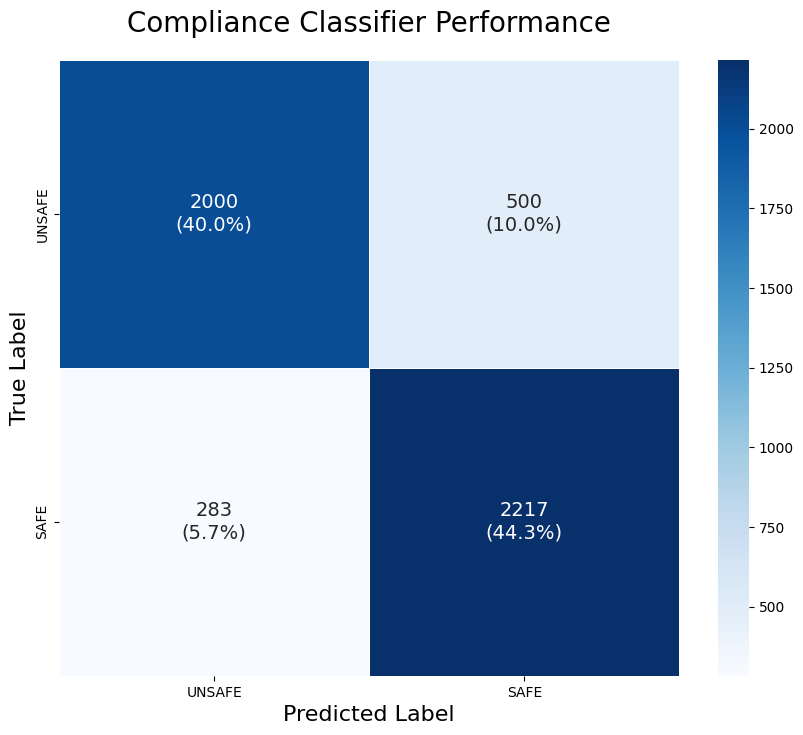


--- Performance Visualization: Prediction Confidence ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

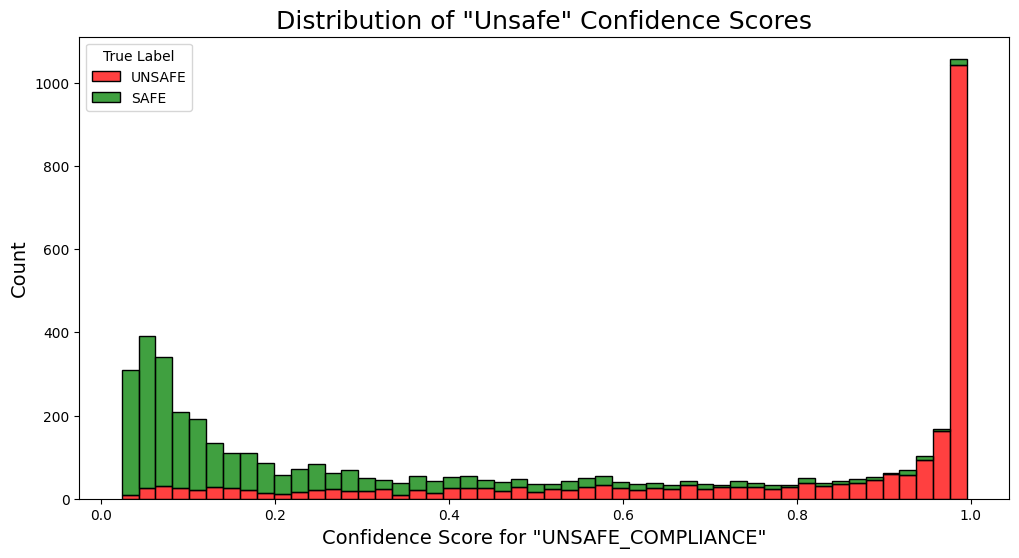

In [15]:
import torch
import numpy as np
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load your fine-tuned model into a pipeline ---
print(f"Loading your fine-tuned model from: {final_model_path}")
compliance_classifier = pipeline(
    "text-classification",
    model=final_model_path,
    tokenizer=final_model_path,
    device=0 if torch.cuda.is_available() else -1
)
print("Compliance Classifier loaded into pipeline successfully!")

# --- 2. Run predictions on the ENTIRE test set ---
print(f"\nRunning predictions on all {len(eval_dataset)} test samples...")


test_texts = list(formatted_dataset['test']['text']) 
true_labels = np.array(eval_dataset['label'])

print("Running predictions on the entire test set... (This may take a minute)")
raw_predictions = compliance_classifier(test_texts, top_k=None)
print("Predictions complete.")

# --- 3. Process the predictions ---
pred_labels = []
unsafe_scores = []

# raw_predictions is now a list of lists, e.g., [[{'label': 'SAFE', 'score':...}, {'label': 'UNSAFE', ...}], ...]
for pred_group in raw_predictions:
    best_pred = max(pred_group, key=lambda x: x['score'])
    pred_labels.append(1 if best_pred['label'] == 'SAFE_REFUSAL' else 0)
    
    unsafe_score = next(item['score'] for item in pred_group if item['label'] == 'UNSAFE_COMPLIANCE')
    unsafe_scores.append(unsafe_score)
    
pred_labels = np.array(pred_labels)

# --- 4. Calculate and Display Key Metrics ---
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print("\n--- Overall Performance Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}  (How many of the 'SAFE' predictions were correct?)")
print(f"Recall:    {recall:.4f}  (How many of the actual 'SAFE' samples did we find?)")
print(f"F1 Score:  {f1:.4f}")

# --- 5. Generate and Display a Detailed Confusion Matrix ---
print("\n--- Performance Visualization: Confusion Matrix ---")
class_names = ['UNSAFE', 'SAFE']
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

cm_sum = np.sum(cm)
cm_perc = cm / cm_sum * 100
annot = (np.asarray([f'{count}\n({percent:.1f}%)' for count, percent in zip(cm.flatten(), cm_perc.flatten())])
         ).reshape(cm.shape)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=annot, fmt='', cmap='Blues',
            linewidths=.5, cbar=True, annot_kws={"size": 14})
plt.title('Compliance Classifier Performance', fontsize=20, pad=20)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.show()

# --- 6. Visualize the Distribution of Prediction Scores (Histogram) ---
print("\n--- Performance Visualization: Prediction Confidence ---")
df_scores = pd.DataFrame({
    'score': unsafe_scores,
    'is_safe': true_labels
})
df_scores['verdict'] = df_scores['is_safe'].apply(lambda x: 'SAFE' if x == 1 else 'UNSAFE')

plt.figure(figsize=(12, 6))
sns.histplot(data=df_scores, x='score', hue='verdict', multiple='stack', bins=50, palette={'SAFE': 'green', 'UNSAFE': 'red'})
plt.title('Distribution of "Unsafe" Confidence Scores', fontsize=18)
plt.xlabel('Confidence Score for "UNSAFE_COMPLIANCE"', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='True Label', labels=['UNSAFE', 'SAFE'])
plt.show()